In [31]:
import numpy as np
import pandas_datareader as web
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

In [47]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [48]:
def get_model(path):
  return load_model(path)

In [49]:
Window=30
def get_data(predday,series):
  # fixed input size to model, last 30 day
    Predday = predday

    # To split the data into 90:10
    Trainsplit = 0.9

    cut = int(series.shape[0]*Trainsplit)

    # train
    closetrain = series[:cut]
    # test
    closetest = series[cut:-(Window+Predday)]
    # forecast for future 7 days
    closeforecast = series[-(Window+Predday):]

    return closetrain,closetest,closeforecast

In [50]:
def windowed_dataset(series, window_size,predday, batch_size = 32, shuffle_buffer= 1000):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + predday, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + predday))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-predday], tf.squeeze(w[-predday:])))
    return ds.batch(batch_size).prefetch(3)

In [61]:
def visualplotloss(dataset,model,z,predday):
    x,y = next(iter(dataset))
    output = model.predict(x)
    timecorr =list(range(z-1,(z-1)+predday))
    for j in range(8):
        plt.ylim(0,0.75)
        plt.plot(x[j])
        plt.plot(timecorr,output[j],"--")
        plt.plot(timecorr,y[j])
        plt.legend(["Input of 30 days","Prediction","Truth Value"])
        plt.show()

In [62]:
# using JD as its not as stable
df=web.DataReader('AAPL',data_source='yahoo',start='04-01-2003',end='07-15-2020')
df.head()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2003-04-01,1.022143,1.005000,1.014286,1.011429,38585400.0,0.875591
2003-04-02,1.049286,1.019286,1.025714,1.042857,42842800.0,0.902799
2003-04-03,1.050000,1.025000,1.040000,1.032857,36428000.0,0.894142
2003-04-04,1.047857,1.027857,1.037143,1.029286,36505000.0,0.891050
2003-04-07,1.067857,1.029286,1.060714,1.035000,49215600.0,0.895997


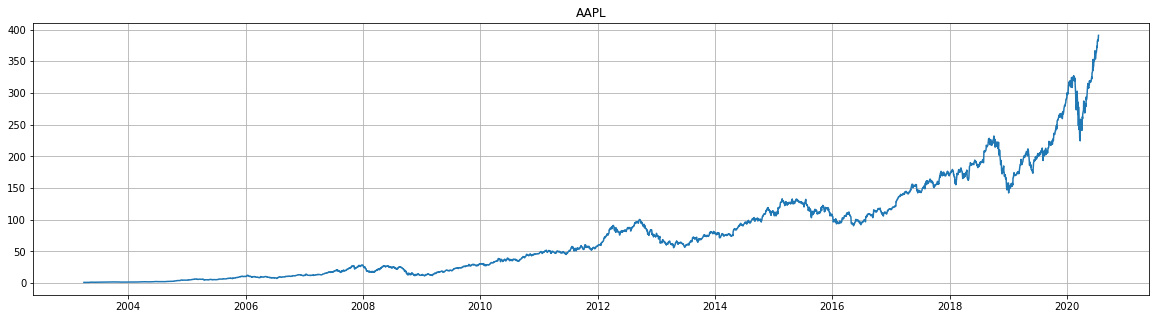

In [63]:
plt.figure(figsize=(20,5))
plt.plot(df.Close)
plt.title("AAPL")
plt.grid()

In [64]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,0.75))
# 0.75 so it's easier for relu to reach

# closing valueŝ
ser = df.Close.values
ser = ser.reshape(-1,1)
# scaled series
series = scaler.fit_transform(ser)

In [65]:
int(series.shape[0]*0.9)

3917

In [66]:
closetrain,closetest,closeforecast=get_data(7,series)

In [67]:
window_size=31
predday=7
trainbatches =  windowed_dataset(closetrain,window_size,predday)
testbatches =  windowed_dataset(closetest,window_size,predday,batch_size=8)

In [68]:
testbatches

<PrefetchDataset shapes: ((None, None, 1), <unknown>), types: (tf.float64, tf.float64)>

In [69]:
path=r'/content/drive/My Drive/LSTM MODEL STOCK/Model1_pred_7days(1).h5'
model=get_model(path)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 128)         768       
_________________________________________________________________
lstm (LSTM)                  (None, None, 128)         131584    
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 128)         131584    
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 4

In [70]:
h = model.fit(trainbatches,epochs=10,validation_data=testbatches,verbose=1)
hist = h.history

Epoch 1/10
122/122 [==============================] - 5s 45ms/step - loss: 2.8887e-05 - mean_squared_error: 5.7775e-05 - val_loss: 2.8912e-04 - val_mean_squared_error: 5.7824e-04
Epoch 2/10
122/122 [==============================] - 4s 35ms/step - loss: 1.4806e-05 - mean_squared_error: 2.9612e-05 - val_loss: 2.0704e-04 - val_mean_squared_error: 4.1408e-04
Epoch 3/10
122/122 [==============================] - 4s 35ms/step - loss: 1.3996e-05 - mean_squared_error: 2.7993e-05 - val_loss: 1.8872e-04 - val_mean_squared_error: 3.7743e-04
Epoch 4/10
122/122 [==============================] - 4s 35ms/step - loss: 1.4080e-05 - mean_squared_error: 2.8159e-05 - val_loss: 1.9236e-04 - val_mean_squared_error: 3.8472e-04
Epoch 5/10
122/122 [==============================] - 4s 35ms/step - loss: 1.4881e-05 - mean_squared_error: 2.9761e-05 - val_loss: 2.5837e-04 - val_mean_squared_error: 5.1675e-04
Epoch 6/10
122/122 [==============================] - 4s 35ms/step - loss: 1.5421e-05 - mean_squared_erro

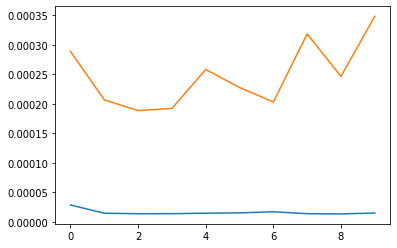

In [71]:
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.show()

In [72]:
x1,y1 = next(iter(testbatches))
output = model.predict(x1)
output.shape

(8, 7)

In [73]:
testbatches

<PrefetchDataset shapes: ((None, None, 1), <unknown>), types: (tf.float64, tf.float64)>

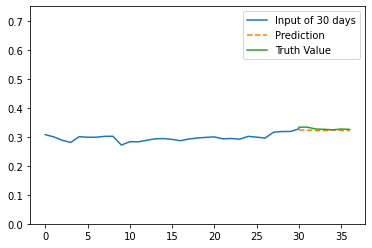

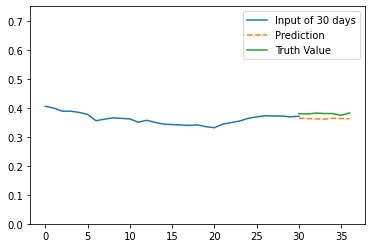

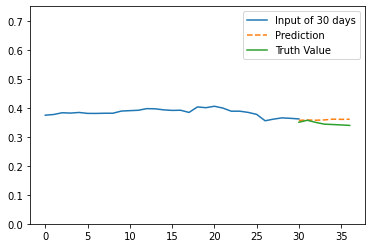

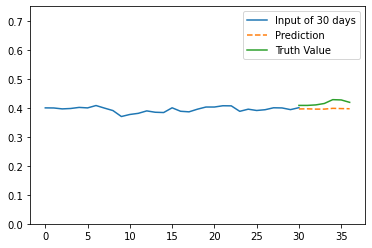

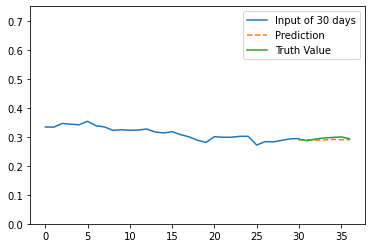

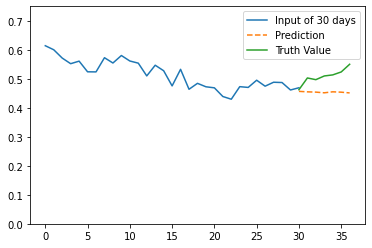

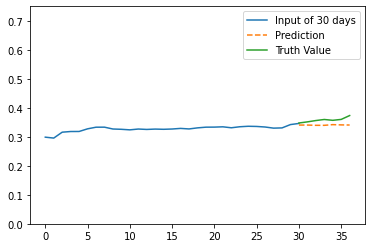

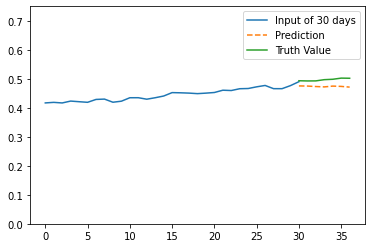

In [74]:
visualplotloss(testbatches,model,window_size,predday)

In [77]:
model.evaluate(testbatches)

46/46 [==============================] - 0s 10ms/step - loss: 3.4858e-04 - mean_squared_error: 6.9716e-04


[0.000348578963894397, 0.000697157927788794]

**Model 2**

In [78]:
path=r'/content/drive/My Drive/LSTM MODEL STOCK/Model2_pred_14days.h5'
model=get_model(path)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 128)         768       
_________________________________________________________________
lstm (LSTM)                  (None, None, 128)         131584    
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 128)         131584    
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 14)                9

In [79]:
closetrain,closetest,closeforecast=get_data(14,series)

In [80]:
window_size=62
predday=14
trainbatches =  windowed_dataset(closetrain,62,14)
testbatches =  windowed_dataset(closetest,62,14,batch_size=8)

In [81]:
h = model.fit(trainbatches,epochs=10,validation_data=testbatches,verbose=1)
hist = h.history

Epoch 1/10
121/121 [==============================] - 8s 70ms/step - loss: 5.1357e-05 - mean_squared_error: 1.0271e-04 - val_loss: 4.0950e-04 - val_mean_squared_error: 8.1901e-04
Epoch 2/10
121/121 [==============================] - 7s 59ms/step - loss: 3.0100e-05 - mean_squared_error: 6.0200e-05 - val_loss: 4.0283e-04 - val_mean_squared_error: 8.0566e-04
Epoch 3/10
121/121 [==============================] - 7s 59ms/step - loss: 2.8173e-05 - mean_squared_error: 5.6346e-05 - val_loss: 3.8890e-04 - val_mean_squared_error: 7.7780e-04
Epoch 4/10
121/121 [==============================] - 7s 59ms/step - loss: 3.0911e-05 - mean_squared_error: 6.1822e-05 - val_loss: 3.8249e-04 - val_mean_squared_error: 7.6499e-04
Epoch 5/10
121/121 [==============================] - 7s 59ms/step - loss: 2.6944e-05 - mean_squared_error: 5.3888e-05 - val_loss: 3.6187e-04 - val_mean_squared_error: 7.2374e-04
Epoch 6/10
121/121 [==============================] - 7s 59ms/step - loss: 2.7280e-05 - mean_squared_erro

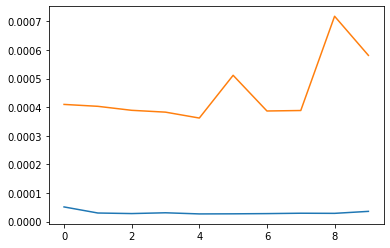

In [82]:
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.show()

In [84]:
x1,y1 = next(iter(testbatches))
output = model.predict(x1)
output.shape

(8, 14)

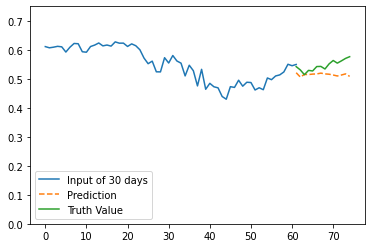

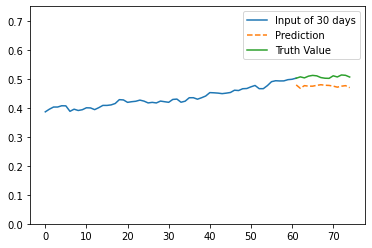

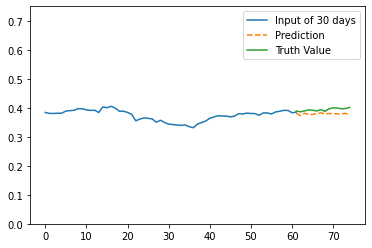

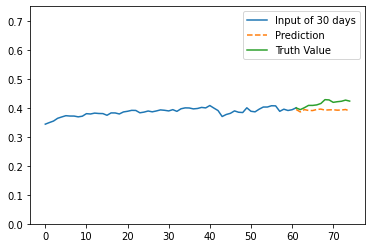

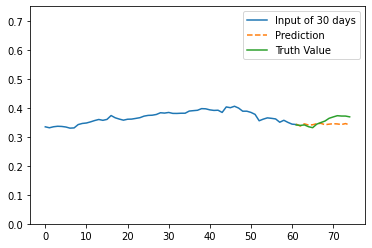

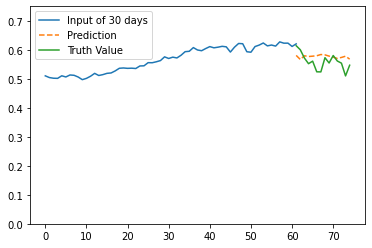

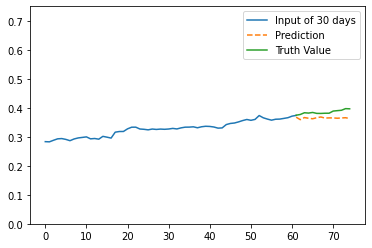

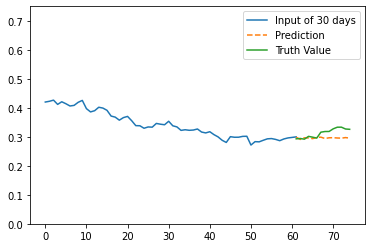

In [85]:
visualplotloss(testbatches,model,window_size,predday)

**Model 3**

In [86]:
path=r'/content/drive/My Drive/LSTM MODEL STOCK/Model_3_Pred21_Days.h5'
model=get_model(path)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 128)         768       
_________________________________________________________________
lstm (LSTM)                  (None, None, 128)         131584    
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 128)         131584    
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 21)                1

In [87]:
closetrain,closetest,closeforecast=get_data(21,series)

In [88]:
window_size=90
predday=21
trainbatches =  windowed_dataset(closetrain,window_size,predday)
testbatches =  windowed_dataset(closetest,window_size,predday,batch_size=8)

In [89]:
h = model.fit(trainbatches,epochs=10,validation_data=testbatches,verbose=1)
hist = h.history

Epoch 1/10
119/119 [==============================] - 11s 92ms/step - loss: 1.6174e-04 - mean_squared_error: 1.6174e-04 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 2/10
119/119 [==============================] - 9s 80ms/step - loss: 8.8192e-05 - mean_squared_error: 8.8192e-05 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 3/10
119/119 [==============================] - 9s 79ms/step - loss: 7.9560e-05 - mean_squared_error: 7.9560e-05 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 4/10
119/119 [==============================] - 9s 79ms/step - loss: 7.8314e-05 - mean_squared_error: 7.8314e-05 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 5/10
119/119 [==============================] - 9s 79ms/step - loss: 7.4546e-05 - mean_squared_error: 7.4546e-05 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 6/10
119/119 [==============================] - 9s 79ms/step - loss: 7.3209e-05 - mean_squared_error: 7.3209e-05 - val_loss: 0.0012 - val_

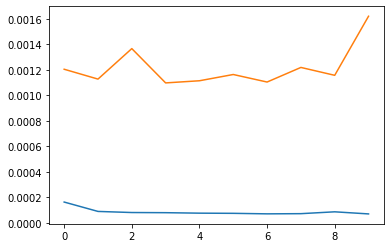

In [90]:
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.show()

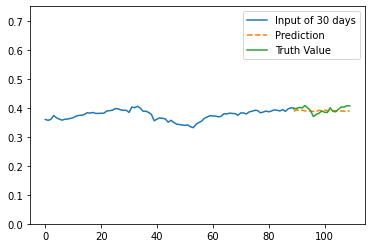

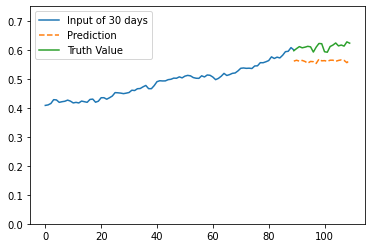

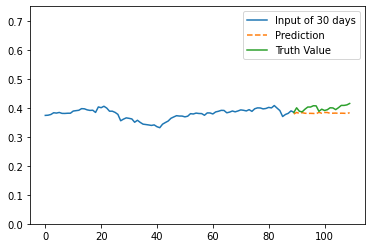

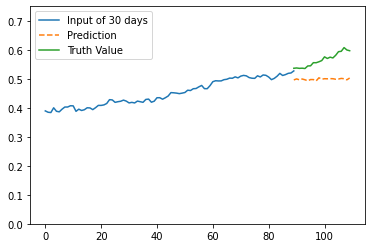

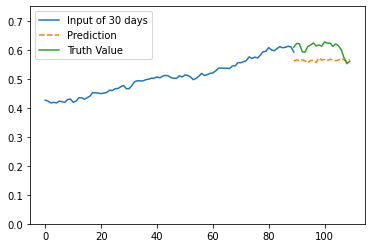

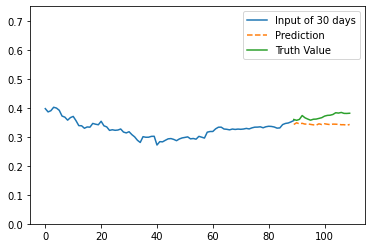

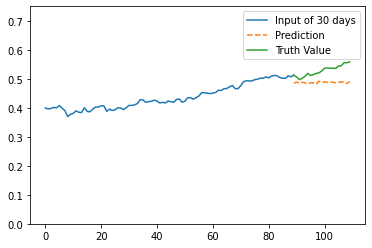

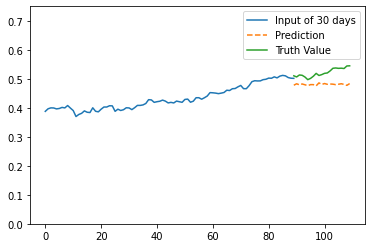

In [91]:
visualplotloss(testbatches,model,window_size,predday)

**Model 4**

In [92]:
path=r'/content/drive/My Drive/LSTM MODEL STOCK/Model_4_Pred28_Days.h5'
model=get_model(path)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 128)         768       
_________________________________________________________________
lstm (LSTM)                  (None, None, 128)         131584    
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 128)         131584    
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 28)                1

In [93]:
closetrain,closetest,closeforecast=get_data(28,series)

In [94]:
window_size=128
predday=28
trainbatches =  windowed_dataset(closetrain,window_size,predday)
testbatches =  windowed_dataset(closetest,window_size,predday,batch_size=8)

In [95]:
h = model.fit(trainbatches,epochs=10,validation_data=testbatches,verbose=1)
hist = h.history

Epoch 1/10
118/118 [==============================] - 12s 106ms/step - loss: 8.4341e-05 - mean_squared_error: 1.6868e-04 - val_loss: 9.4840e-04 - val_mean_squared_error: 0.0019
Epoch 2/10
118/118 [==============================] - 10s 88ms/step - loss: 4.9967e-05 - mean_squared_error: 9.9934e-05 - val_loss: 8.7350e-04 - val_mean_squared_error: 0.0017
Epoch 3/10
118/118 [==============================] - 10s 89ms/step - loss: 4.9467e-05 - mean_squared_error: 9.8934e-05 - val_loss: 9.4563e-04 - val_mean_squared_error: 0.0019
Epoch 4/10
118/118 [==============================] - 10s 88ms/step - loss: 5.0089e-05 - mean_squared_error: 1.0018e-04 - val_loss: 8.4621e-04 - val_mean_squared_error: 0.0017
Epoch 5/10
118/118 [==============================] - 10s 89ms/step - loss: 4.8324e-05 - mean_squared_error: 9.6648e-05 - val_loss: 8.4812e-04 - val_mean_squared_error: 0.0017
Epoch 6/10
118/118 [==============================] - 10s 88ms/step - loss: 4.6995e-05 - mean_squared_error: 9.3991e-05

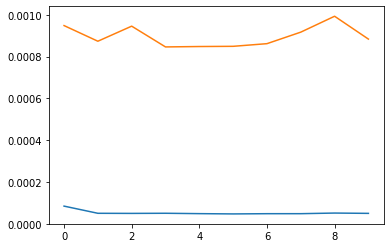

In [96]:
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.show()

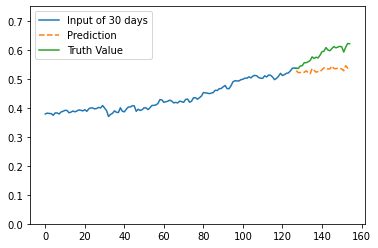

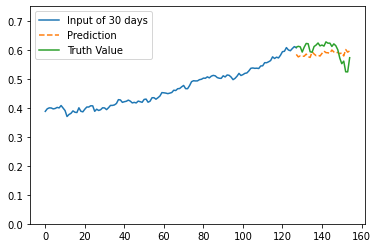

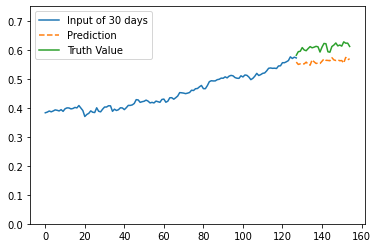

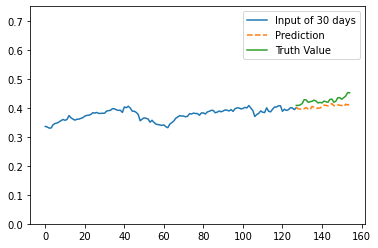

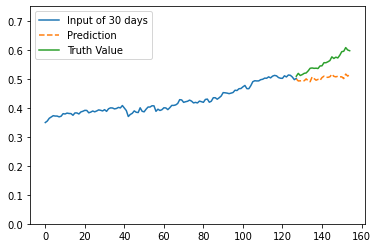

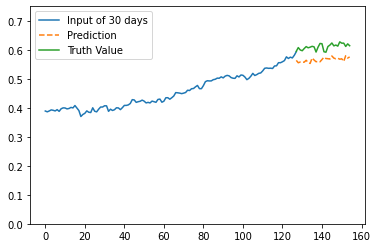

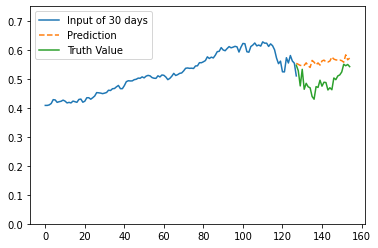

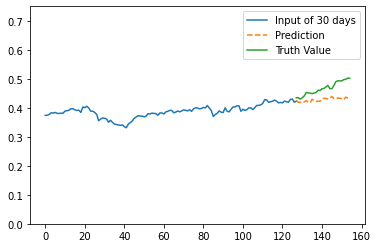

In [97]:
visualplotloss(testbatches,model,window_size,predday)

**Model 5**

In [98]:
path=r'/content/drive/My Drive/LSTM MODEL STOCK/Model5_Pred_35Days.h5'
model=get_model(path)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 128)         768       
_________________________________________________________________
lstm (LSTM)                  (None, None, 128)         131584    
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 128)         131584    
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 35)                2

In [99]:
closetrain,closetest,closeforecast=get_data(35,series)

In [100]:
window_size=150
predday=35
trainbatches =  windowed_dataset(closetrain,150,35)
testbatches =  windowed_dataset(closetest,150,35,batch_size=8)

In [101]:
h = model.fit(trainbatches,epochs=10,validation_data=testbatches,verbose=1)
hist = h.history

Epoch 1/10
117/117 [==============================] - 14s 121ms/step - loss: 7.2559e-05 - mean_squared_error: 1.4512e-04 - val_loss: 8.4105e-04 - val_mean_squared_error: 0.0017
Epoch 2/10
117/117 [==============================] - 10s 88ms/step - loss: 5.6398e-05 - mean_squared_error: 1.1280e-04 - val_loss: 7.9679e-04 - val_mean_squared_error: 0.0016
Epoch 3/10
117/117 [==============================] - 10s 88ms/step - loss: 6.0494e-05 - mean_squared_error: 1.2099e-04 - val_loss: 8.7087e-04 - val_mean_squared_error: 0.0017
Epoch 4/10
117/117 [==============================] - 10s 89ms/step - loss: 5.4412e-05 - mean_squared_error: 1.0882e-04 - val_loss: 8.0990e-04 - val_mean_squared_error: 0.0016
Epoch 5/10
117/117 [==============================] - 10s 88ms/step - loss: 5.3652e-05 - mean_squared_error: 1.0730e-04 - val_loss: 8.2787e-04 - val_mean_squared_error: 0.0017
Epoch 6/10
117/117 [==============================] - 10s 88ms/step - loss: 5.1657e-05 - mean_squared_error: 1.0331e-04

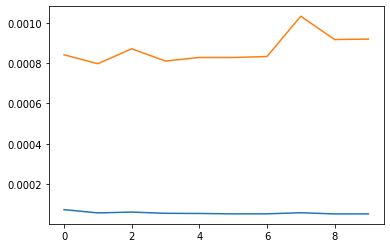

In [102]:
plt.plot(hist["loss"])
plt.plot(hist["val_loss"])
plt.show()

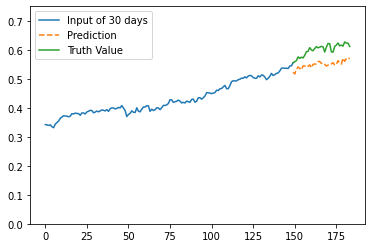

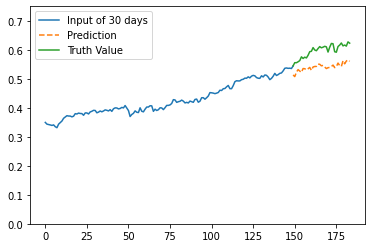

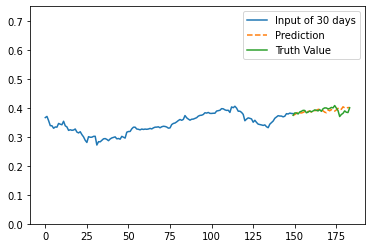

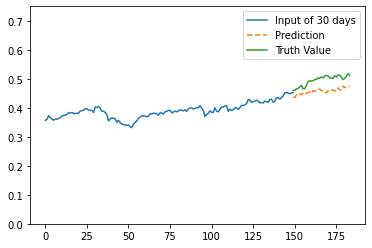

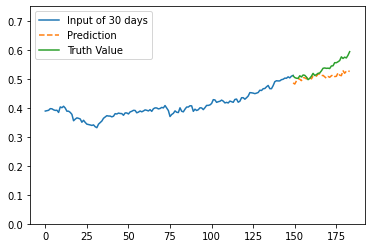

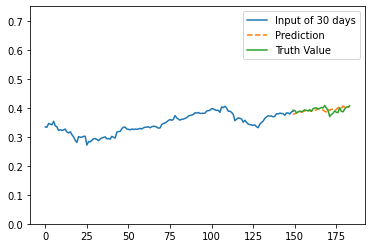

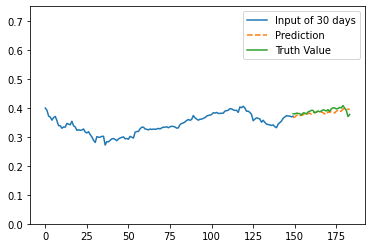

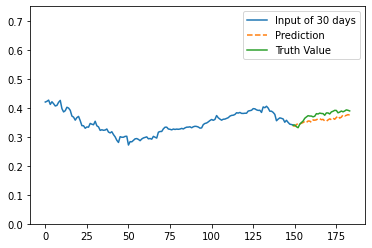

In [103]:
visualplotloss(testbatches,model,window_size,predday)